In [51]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import itertools
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Prepare the Data

In [2]:
df = pd.read_csv('Binance_BTCUSDT_1min.csv')
df = df.iloc[:,:6]
df.columns=['timestamp','open', 'high', 'low', 'close', 'volume']
df.reset_index(drop=True, inplace=True)
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [3]:
df

,open,high,low,close,volume
timestamp,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2024-04-20 18:44:00,64972.31,64987.50,64963.04,64987.49,4.300080
2024-04-20 18:45:00,64987.50,64993.89,64976.70,64993.88,4.761690
2024-04-20 18:46:00,64993.88,64993.89,64950.00,64953.04,8.075220


In [4]:
def resample_df(df, freq):
    resampled_open = df.open.resample(freq).first()
    resampled_high = df.high.resample(freq).max()
    resampled_low = df.low.resample(freq).min()
    resampled_close = df.close.resample(freq).last()
    resampled_volume = df.volume.resample(freq).sum()
    new_df = pd.concat([resampled_open, resampled_high, resampled_low, resampled_close, resampled_volume], axis=1)
    new_df.dropna(inplace=True)
    return new_df

In [5]:
def calc_price(new_df):
    new_df['price'] = new_df.open.shift(-1)

In [6]:
def calc_rvi(new_df, std_sample_window, rvi_length): #14; 3 is my default
    new_df['diff'] = new_df['close'].diff()
    new_df['rolling_std'] = new_df['close'].rolling(window=std_sample_window).std()
    new_df['gain'] = np.where(new_df['diff'] > 0, new_df['rolling_std'], 0)
    new_df['loss'] = np.where(new_df['diff'] < 0, new_df['rolling_std'], 0)
    new_df['upper'] = ta.ema(new_df['gain'], rvi_length)
    new_df['lower'] = ta.ema(new_df['loss'], rvi_length)
    new_df['rvi'] = new_df['upper'] / (new_df['upper'] + new_df['lower']) * 100
    return new_df

In [7]:
def calc_rvibbands(new_df, rvi_ma_length, std_multiple):
    bb_df = ta.bbands(new_df['rvi'], length=rvi_ma_length, std=std_multiple)
    new_df = pd.concat([new_df, bb_df], axis=1)
    return new_df

In [8]:
def calc_ma(new_df, ma_length):
    new_df['ma'] = ta.sma(new_df['close'], ma_length)

In [9]:
def calc_cols(new_df):
    new_df['trend_status'] = 0
    new_df['volatility_breakout'] = 0
    new_df['volatility_revert'] = 0
    
    trendup = new_df['close'] > new_df['ma']
    trenddown = new_df['close'] < new_df['ma']
    new_df.loc[trendup, 'trend_status'] = 1
    new_df.loc[trenddown, 'trend_status'] = -1 

    
    breakabove = new_df['rvi'] > new_df[f'{new_df.columns[14]}']
    breakbelow = new_df['rvi'] < new_df[f'{new_df.columns[12]}']
    new_df.loc[breakabove, 'volatility_breakout'] = 1
    new_df.loc[breakbelow, 'volatility_breakout'] = -1

    

    prev_breakabove = breakabove.shift(fill_value=False)
    prev_breakbelow = breakbelow.shift(fill_value=False)
    revertabove = prev_breakbelow & ~breakbelow
    revertbelow = prev_breakabove & ~breakabove
    new_df.loc[revertabove, 'volatility_revert'] = 1
    new_df.loc[revertbelow, 'volatility_revert'] = -1
    
    return new_df

In [10]:
def calc_signals(new_df):
    new_df['buy_signal'] = np.where(((new_df.trend_status > 0) & (new_df.volatility_revert > 0)), True, False)
    new_df['sell_signal'] = np.where(((new_df.trend_status < 0) & (new_df.volatility_revert < 0)), True, False)

In [19]:
new_df = resample_df(df, '1H')
calc_rvi(new_df, 3, 14)
new_df = calc_rvibbands(new_df, 55, 2)
calc_ma(new_df, 55)
calc_cols(new_df)
calc_price(new_df)
calc_signals(new_df)
new_df.dropna(inplace=True)
new_df

,open,high,low,close,volume,diff,rolling_std,gain,loss,upper,...,BBU_55_2,BBB_55_2,BBP_55_2,ma,trend_status,volatility_breakout,volatility_revert,price,buy_signal,sell_signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-19 23:00:00,4139.98,4139.98,4120.78,4139.98,0.052699,0.00,37.960780,0.000000,0.000000,15.860410,...,73.776382,117.140171,0.699061,4169.690545,-1,0,0,4139.98,False,False
2017-08-20 00:00:00,4139.98,4139.98,4044.00,4086.09,2.343924,-53.89,31.113406,0.000000,31.113406,13.745689,...,72.865905,115.483074,0.550862,4165.996909,-1,0,0,4086.09,False,False
2017-08-20 01:00:00,4086.09,4086.09,4052.82,4082.53,1.061151,-3.56,32.190341,0.000000,32.190341,11.912930,...,72.580289,115.795927,0.417587,4162.825273,-1,0,0,4082.53,False,False
2017-08-20 02:00:00,4082.53,4124.69,4082.53,4124.69,2.858561,42.16,23.381257,23.381257,0.000000,13.442040,...,72.082046,115.142175,0.544630,4159.179091,-1,0,0,4124.69,False,False
2017-08-20 03:00:00,4124.69,4124.69,4094.62,4094.62,0.347647,-30.07,21.709593,0.000000,21.709593,11.649768,...,70.990603,113.394426,0.454411,4154.595091,-1,0,0,4094.62,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-20 13:00:00,63824.08,64047.92,63798.92,63875.53,813.925390,51.45,86.274891,86.274891,0.000000,71.375025,...,74.234494,82.076966,0.465026,63510.733091,1,0,0,63875.53,False,False
2024-04-20 14:00:00,63875.53,63984.79,63746.00,63935.33,491.918590,59.80,55.677203,55.677203,0.000000,69.281982,...,74.286817,81.984139,0.529170,63560.864909,1,0,0,63935.33,False,False
2024-04-20 15:00:00,63935.33,64960.37,63790.00,64808.35,1851.287500,873.02,522.157881,522.157881,0.000000,129.665435,...,75.201830,83.692116,0.920402,63623.998727,1,0,0,64808.35,False,False


In [24]:
len(new_df[new_df['buy_signal'] == True])

329

In [ ]:
#PREP_DF
"""
new_df = resample_df(df, freq)
calc_rvi(new_df, std_sample_window, rvi_length)
calc_rvibbands(new_df, rvi_ma_length, std_multiple)
calc_ma(new_df, ma_length)
calc_cols(new_df)
calc_price(new_df)
calc_signals(new_df)
"""

# Backtest the strategy

In [38]:
def backtest(df, freq, std_sample_window, rvi_length, rvi_ma_length, std_multiple, ma_length, tp, sl):
    new_df = resample_df(df, freq)
    calc_rvi(new_df, std_sample_window, rvi_length)
    new_df = calc_rvibbands(new_df, rvi_ma_length, std_multiple)
    calc_ma(new_df, ma_length)
    calc_cols(new_df)
    calc_price(new_df)
    calc_signals(new_df)
    new_df.dropna(inplace=True)
    
    #Error handle for no buy signals
    if len(new_df[new_df.buy_signal > 0]) | len(new_df[new_df.sell_signal > 0]) < 1:
        empty_result = pd.DataFrame({
            "entry_time": [0],
            "entry_price": [0],
            "tp_target": [0],
            "sl_target": [0],
            "exit_time": [0],
            "exit_price": [0],
            "pnl": [0],
            "equity": [0],
            "pnl_perc": [0]
        })
        long_winrate = 0
        long_amount = 0
        long_equity_value = 0
        short_winrate = 0
        short_amount = 0
        short_equity_value = 0
        overall_winrate = 0
        overall_amount = 0
        overall_equity_value = 0
        print('could not find trades')
    
        return long_winrate, long_amount, long_equity_value, short_winrate, short_amount, short_equity_value, overall_winrate, overall_amount, overall_equity_value
        return empty_result
    
    #Initialise Varibles
    in_sell_position = False
    in_buy_postition = False
    buy_trades = []
    current_buy_trade = {}
    sell_trades = []
    current_sell_trade = {}
    #Need to come back to this logic later, might be a better way to acheive by just append buy & sell data
    initial_equity = 1000
    equity = initial_equity
            
    for i in range(len(new_df)-1):
    #Check exit conditions
        if in_buy_postition:
            if new_df.iloc[i].low < current_buy_trade ["sl_price"]:
                current_buy_trade ["exit_price"] = current_buy_trade ["sl_price"]
                pnl = (current_buy_trade ["exit_price"] - current_buy_trade ["entry_price"])
                pnl_perc = sl - 1
                equity = equity + (equity * pnl_perc)
                #equity_str = "{:.2f}".format(equity)
                buy_trades.append({
                    "entry_time":current_buy_trade ["entry_time"],
                    "entry_price":current_buy_trade ["entry_price"],
                    "side":current_buy_trade["side"],
                    "tp_target":current_buy_trade ["tp_price"],
                    "sl_target":current_buy_trade ["sl_price"],
                    "exit_time":new_df.iloc[i].name,
                    "exit_price":current_buy_trade ["sl_price"],
                    "pnl": pnl,
                    "pnl_perc": pnl_perc,
                    "equity": equity
                })
                current_buy_trade  = {}
                in_buy_postition = False

            elif new_df.iloc[i].high > current_buy_trade ["tp_price"]:
                current_buy_trade ["exit_price"] = current_buy_trade ["tp_price"]
                pnl = (current_buy_trade ["exit_price"] - current_buy_trade ["entry_price"])
                pnl_perc = tp - 1
                equity = equity + (equity * pnl_perc)
                #equity_str = "{:.2f}".format(equity)
                buy_trades.append({
                    "entry_time":current_buy_trade ["entry_time"],
                    "entry_price":current_buy_trade ["entry_price"],
                    "tp_target":current_buy_trade ["tp_price"],
                    "side":current_buy_trade["side"],
                    "sl_target":current_buy_trade ["sl_price"],
                    "exit_time":new_df.iloc[i].name,
                    "exit_price":current_buy_trade ["tp_price"],
                    "pnl":pnl,
                    "pnl_perc": pnl_perc,
                    "equity": equity
                })
                current_buy_trade  = {}
                in_buy_postition = False
                
        if in_sell_position:
            if new_df.iloc[i].high > current_sell_trade["sl_price"]:
                current_sell_trade["exit_price"] = current_sell_trade["sl_price"]
                pnl = (current_sell_trade["entry_price"] - current_sell_trade["exit_price"])
                pnl_perc = sl - 1
                equity = equity + (equity * pnl_perc)
                #equity_str = "{:.2f}".format(equity)
                sell_trades.append({
                    "entry_time":current_sell_trade["entry_time"],
                    "entry_price":current_sell_trade["entry_price"],
                    "side":current_sell_trade["side"],
                    "tp_target":current_sell_trade["tp_price"],
                    "sl_target":current_sell_trade["sl_price"],
                    "exit_time":new_df.iloc[i].name,
                    "exit_price":current_sell_trade["sl_price"],
                    "pnl": pnl,
                    "pnl_perc": pnl_perc,
                    "equity": equity
                })
                current_sell_trade = {}
                in_sell_position = False

            elif new_df.iloc[i].low < current_sell_trade["tp_price"]:
                current_sell_trade["exit_price"] = current_sell_trade["tp_price"]
                pnl = (current_sell_trade["entry_price"] - current_sell_trade["exit_price"])
                pnl_perc = tp - 1
                equity = equity + (equity * pnl_perc)
                #equity_str = "{:.2f}".format(equity)
                sell_trades.append({
                    "entry_time":current_sell_trade["entry_time"],
                    "entry_price":current_sell_trade["entry_price"],
                    "side":current_sell_trade["side"],
                    "tp_target":current_sell_trade["tp_price"],
                    "sl_target":current_sell_trade["sl_price"],
                    "exit_time":new_df.iloc[i].name,
                    "exit_price":current_sell_trade["tp_price"],
                    "pnl":pnl,
                    "pnl_perc": pnl_perc,
                    "equity": equity
                })
                current_sell_trade = {}
                in_sell_position = False


        #Check entry conditions
        if not in_buy_postition:
            if new_df.iloc[i].buy_signal == True:
                current_buy_trade["entry_price"] = new_df.iloc[i].price
                current_buy_trade["entry_time"] = new_df.iloc[i+1].name
                current_buy_trade["side"] = "long"
                current_buy_trade["tp_price"] = new_df.iloc[i].price*tp
                current_buy_trade["sl_price"] = new_df.iloc[i].price*sl
                #current_trade["base_value"] = trade_amount/new_df.iloc[i].price
                #current_trade["quote_value"] = trade_amount
                in_buy_postition = True

        if not in_sell_position:
            if new_df.iloc[i].sell_signal == True:
                current_sell_trade["entry_price"] = new_df.iloc[i].price
                current_sell_trade["entry_time"] = new_df.iloc[i+1].name
                current_sell_trade["side"] = "short"
                current_sell_trade["tp_price"] = new_df.iloc[i].price*(1-tp+1)
                current_sell_trade["sl_price"] = new_df.iloc[i].price*(1-sl+1)
                #current_trade["base_value"] = trade_amount/new_df.iloc[i].price
                #current_trade["quote_value"] = trade_amount
                in_sell_position = True
                
    
    
    #prepare all trades df for future calculations
    all_trades = buy_trades + sell_trades
    df_all_trades = pd.DataFrame(all_trades)
    
    #long results
    long_trades = df_all_trades[df_all_trades.side == "long"]
    long_winrate = round(len(long_trades.loc[long_trades.pnl.values>0])/len(long_trades)*100,2)
    long_amount = len(long_trades)
    long_equity_value = round(long_trades['equity'].iloc[-1], 2)

    #short results
    short_trades = df_all_trades[df_all_trades.side == "short"]
    short_winrate = round(len(short_trades.loc[short_trades.pnl.values>0])/len(short_trades)*100,2)
    short_amount = len(short_trades)
    short_equity_value = round(short_trades['equity'].iloc[-1], 2)
    

    #overall results
    overall_winrate = round((long_winrate+short_winrate)/2,2)
    overall_amount = len(df_all_trades)
    overall_equity_value = round((long_equity_value+short_equity_value)/2,2)
    
    return long_winrate, long_amount, long_equity_value, short_winrate, short_amount, short_equity_value, overall_winrate, overall_amount, overall_equity_value
    #return df_all_trades

In [40]:
def backtest_trades(df, freq, std_sample_window, rvi_length, rvi_ma_length, std_multiple, ma_length, tp, sl):

    new_df = resample_df(df, freq)
    calc_rvi(new_df, std_sample_window, rvi_length)
    new_df = calc_rvibbands(new_df, rvi_ma_length, std_multiple)
    calc_ma(new_df, ma_length)
    calc_cols(new_df)
    calc_price(new_df)
    calc_signals(new_df)
    new_df.dropna(inplace=True)
    
    #Error handle for no buy signals
    if len(new_df[new_df.buy_signal > 0]) | len(new_df[new_df.sell_signal > 0]) < 1:
        empty_result = pd.DataFrame({
            "entry_time": [0],
            "entry_price": [0],
            "tp_target": [0],
            "sl_target": [0],
            "exit_time": [0],
            "exit_price": [0],
            "pnl": [0],
            "equity": [0],
            "pnl_perc": [0]
        })
        long_winrate = 0
        long_amount = 0
        long_equity_value = 0
        short_winrate = 0
        short_amount = 0
        short_equity_value = 0
        overall_winrate = 0
        overall_amount = 0
        overall_equity_value = 0
        print('could not find trades')
    
        return long_winrate, long_amount, long_equity_value, short_winrate, short_amount, short_equity_value, overall_winrate, overall_amount, overall_equity_value
        return empty_result
    
    #Initialise Varibles
    in_sell_position = False
    in_buy_postition = False
    buy_trades = []
    current_buy_trade = {}
    sell_trades = []
    current_sell_trade = {}
    #Need to come back to this logic later, might be a better way to acheive by just append buy & sell data
    initial_equity = 1000
    equity = initial_equity
            
    for i in range(len(new_df)-1):
    #Check exit conditions
        if in_buy_postition:
            if new_df.iloc[i].low < current_buy_trade ["sl_price"]:
                current_buy_trade ["exit_price"] = current_buy_trade ["sl_price"]
                pnl = (current_buy_trade ["exit_price"] - current_buy_trade ["entry_price"])
                pnl_perc = sl - 1
                equity = equity + (equity * pnl_perc)
                #equity_str = "{:.2f}".format(equity)
                buy_trades.append({
                    "entry_time":current_buy_trade ["entry_time"],
                    "entry_price":current_buy_trade ["entry_price"],
                    "side":current_buy_trade["side"],
                    "tp_target":current_buy_trade ["tp_price"],
                    "sl_target":current_buy_trade ["sl_price"],
                    "exit_time":new_df.iloc[i].name,
                    "exit_price":current_buy_trade ["sl_price"],
                    "pnl": pnl,
                    "pnl_perc": pnl_perc,
                    "equity": equity
                })
                current_buy_trade  = {}
                in_buy_postition = False

            elif new_df.iloc[i].high > current_buy_trade ["tp_price"]:
                current_buy_trade ["exit_price"] = current_buy_trade ["tp_price"]
                pnl = (current_buy_trade ["exit_price"] - current_buy_trade ["entry_price"])
                pnl_perc = tp - 1
                equity = equity + (equity * pnl_perc)
                #equity_str = "{:.2f}".format(equity)
                buy_trades.append({
                    "entry_time":current_buy_trade ["entry_time"],
                    "entry_price":current_buy_trade ["entry_price"],
                    "tp_target":current_buy_trade ["tp_price"],
                    "side":current_buy_trade["side"],
                    "sl_target":current_buy_trade ["sl_price"],
                    "exit_time":new_df.iloc[i].name,
                    "exit_price":current_buy_trade ["tp_price"],
                    "pnl":pnl,
                    "pnl_perc": pnl_perc,
                    "equity": equity
                })
                current_buy_trade  = {}
                in_buy_postition = False
                
        if in_sell_position:
            if new_df.iloc[i].high > current_sell_trade["sl_price"]:
                current_sell_trade["exit_price"] = current_sell_trade["sl_price"]
                pnl = (current_sell_trade["entry_price"] - current_sell_trade["exit_price"])
                pnl_perc = sl - 1
                equity = equity + (equity * pnl_perc)
                #equity_str = "{:.2f}".format(equity)
                sell_trades.append({
                    "entry_time":current_sell_trade["entry_time"],
                    "entry_price":current_sell_trade["entry_price"],
                    "side":current_sell_trade["side"],
                    "tp_target":current_sell_trade["tp_price"],
                    "sl_target":current_sell_trade["sl_price"],
                    "exit_time":new_df.iloc[i].name,
                    "exit_price":current_sell_trade["sl_price"],
                    "pnl": pnl,
                    "pnl_perc": pnl_perc,
                    "equity": equity
                })
                current_sell_trade = {}
                in_sell_position = False

            elif new_df.iloc[i].low < current_sell_trade["tp_price"]:
                current_sell_trade["exit_price"] = current_sell_trade["tp_price"]
                pnl = (current_sell_trade["entry_price"] - current_sell_trade["exit_price"])
                pnl_perc = tp - 1
                equity = equity + (equity * pnl_perc)
                #equity_str = "{:.2f}".format(equity)
                sell_trades.append({
                    "entry_time":current_sell_trade["entry_time"],
                    "entry_price":current_sell_trade["entry_price"],
                    "side":current_sell_trade["side"],
                    "tp_target":current_sell_trade["tp_price"],
                    "sl_target":current_sell_trade["sl_price"],
                    "exit_time":new_df.iloc[i].name,
                    "exit_price":current_sell_trade["tp_price"],
                    "pnl":pnl,
                    "pnl_perc": pnl_perc,
                    "equity": equity
                })
                current_sell_trade = {}
                in_sell_position = False


        #Check entry conditions
        if not in_buy_postition:
            if new_df.iloc[i].buy_signal == True:
                current_buy_trade["entry_price"] = new_df.iloc[i].price
                current_buy_trade["entry_time"] = new_df.iloc[i+1].name
                current_buy_trade["side"] = "long"
                current_buy_trade["tp_price"] = new_df.iloc[i].price*tp
                current_buy_trade["sl_price"] = new_df.iloc[i].price*sl
                #current_trade["base_value"] = trade_amount/new_df.iloc[i].price
                #current_trade["quote_value"] = trade_amount
                in_buy_postition = True

        if not in_sell_position:
            if new_df.iloc[i].sell_signal == True:
                current_sell_trade["entry_price"] = new_df.iloc[i].price
                current_sell_trade["entry_time"] = new_df.iloc[i+1].name
                current_sell_trade["side"] = "short"
                current_sell_trade["tp_price"] = new_df.iloc[i].price*(1-tp+1)
                current_sell_trade["sl_price"] = new_df.iloc[i].price*(1-sl+1)
                #current_trade["base_value"] = trade_amount/new_df.iloc[i].price
                #current_trade["quote_value"] = trade_amount
                in_sell_position = True
                
    
    
    #prepare all trades df for future calculations
    all_trades = buy_trades + sell_trades
    df_all_trades = pd.DataFrame(all_trades)
    
    #long results
    long_trades = df_all_trades[df_all_trades.side == "long"]
    long_winrate = round(len(long_trades.loc[long_trades.pnl.values>0])/len(long_trades)*100,2)
    long_amount = len(long_trades)
    long_equity_value = round(long_trades['equity'].iloc[-1], 2)

    #short results
    short_trades = df_all_trades[df_all_trades.side == "short"]
    short_winrate = round(len(short_trades.loc[short_trades.pnl.values>0])/len(short_trades)*100,2)
    short_amount = len(short_trades)
    short_equity_value = round(short_trades['equity'].iloc[-1], 2)
    

    #overall results
    overall_winrate = round((long_winrate+short_winrate)/2,2)
    overall_amount = len(df_all_trades)
    overall_equity_value = round((long_equity_value+short_equity_value)/2,2)
    
    #return long_winrate, long_amount, long_equity_value, short_winrate, short_amount, short_equity_value, overall_winrate, overall_amount, overall_equity_value
    return df_all_trades

In [41]:
#def backtest(df, freq, std_sample_window, rvi_length, rvi_ma_length, std_multiple, ma_length, tp, sl):
#def backtest(df, freq, std_sample_window, rvi_length, rvi_ma_length, std_multiple, ma_length, tp, sl):

    #new_df = resample_df(df, freq)
    #calc_rvi(new_df, std_sample_window, rvi_length)
    #calc_rvibbands(new_df, rvi_ma_length, std_multiple)
    #calc_ma(new_df, ma_length)
    #calc_cols(new_df)
    #calc_price(new_df)
    #calc_signals(new_df)
    #new_df.dropna(inplace=True)

"""
new_df = resample_df(df, '1H')
calc_rvi(new_df, 3, 14)
new_df = calc_rvibbands(new_df, 55, 2)
calc_ma(new_df, 55)
calc_cols(new_df)
calc_price(new_df)
calc_signals(new_df)
new_df
"""

"\nnew_df = resample_df(df, '1H')\ncalc_rvi(new_df, 3, 14)\nnew_df = calc_rvibbands(new_df, 55, 2)\ncalc_ma(new_df, 55)\ncalc_cols(new_df)\ncalc_price(new_df)\ncalc_signals(new_df)\nnew_df\n"

In [75]:
backtest(df=df, freq="1H", std_sample_window=3, rvi_length=14, rvi_ma_length=21, std_multiple=2, ma_length=55, tp=1.02, sl=0.99)

(33.76, 631, 1078.22, 34.05, 514, 1057.08, 33.91, 1145, 1067.65)

In [68]:
#summary
#long_data
amt_l = len(long_trades)
wr_l = round((len(long_trades[long_trades.pnl_perc>0])/amt_l*100),2)
final_equity_l = round(long_trades.iloc[len(long_trades)-1].equity, 2)
roi_l = round(final_equity_l/1000*100,2)
rr_l = round(long_trades[long_trades.pnl_perc>0].iloc[0].pnl_perc,2)/abs(round(long_trades[long_trades.pnl_perc<0].iloc[0].pnl_perc,2))

#short_data
amt_s = len(short_trades)
wr_s = round((len(short_trades[short_trades.pnl_perc>0])/amt_s*100), 2)
final_equity_s = round(short_trades.iloc[len(short_trades)-1].equity, 2)
roi_s = round(final_equity_s/1000*100,2)
rr_s = round(short_trades[short_trades.pnl_perc>0].iloc[0].pnl_perc,2)/abs(round(short_trades[short_trades.pnl_perc<0].iloc[0].pnl_perc,2))

print('/////////////////////////')
print('Long strategy summary:')
print('/////////////////////////')
print('')
print(f'Amount of trades: {amt_l} over XXX days in position XXX % of the time with an average trade duration of XXX ')
print('')
print(f'Final equity of: {final_equity_l} USD using initial of 1000 USD with return of {roi_l} % ')
print('')
print(f'Winrate of: {wr_l} % with Risk Reward ratio of {rr_l}')
print('')
print('//////////////////////////')
print('Short strategy summary:')
print('//////////////////////////')
print('')
print(f'Amount of trades: {amt_s} over XXX days in position XXX % of the time with an average trade duration of XXX ')
print('')
print(f'Final equity of: {final_equity_s} USD using initial of 1000 USD with return of {roi_s} % ')
print('')
print(f'Winrate of: {wr_s} % with Risk Reward ratio of {rr_s}')
print('')
print('//////////////////////////')
print('Overall strategy summary:')
print('//////////////////////////')
print('')
print(f'Total Trades: {amt_l + amt_s} over XXX days in position XXX % of the time with an average trade duration of XXX ')
print('')
print(f'Final equity of: {final_equity_l + final_equity_s} USD using initial of 2000 USD with return of {(roi_l + roi_s)/2} % ')
print('')
print(f'Winrate of: {(wr_l + wr_s)/2} % with Risk Reward ratio of {rr_s}')
print('')


/////////////////////////
Long strategy summary:
/////////////////////////

Amount of trades: 272 over XXX days in position XXX % of the time with an average trade duration of XXX 

Final equity of: 1091.17 USD using initial of 1000 USD with return of 109.12 % 

Winrate of: 45.96 % with Risk Reward ratio of 1.0

//////////////////////////
Short strategy summary:
//////////////////////////

Amount of trades: 213 over XXX days in position XXX % of the time with an average trade duration of XXX 

Final equity of: 1074.8 USD using initial of 1000 USD with return of 107.48 % 

Winrate of: 40.85 % with Risk Reward ratio of 1.0

//////////////////////////
Overall strategy summary:
//////////////////////////

Total Trades: 485 over XXX days in position XXX % of the time with an average trade duration of XXX 

Final equity of: 2165.9700000000003 USD using initial of 2000 USD with return of 108.30000000000001 % 

Winrate of: 43.405 % with Risk Reward ratio of 1.0



# Visualise

In [87]:
new_df = resample_df(df, '1H')
calc_rvi(new_df, 3, 14)
new_df = calc_rvibbands(new_df, 21, 2)
calc_ma(new_df, 55)
calc_cols(new_df)
calc_price(new_df)
calc_signals(new_df)
new_df

,open,high,low,close,volume,diff,rolling_std,gain,loss,upper,...,BBU_21_2,BBB_21_2,BBP_21_2,ma,trend_status,volatility_breakout,volatility_revert,price,buy_signal,sell_signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN,NaN,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,0,0,0,4308.83,False,False
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,6.49,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,0,0,0,4315.32,False,False
2017-08-17 06:00:00,4315.32,4345.45,4309.37,4324.35,7.229691,9.03,7.794564,7.794564,0.000000,NaN,...,NaN,NaN,NaN,NaN,0,0,0,4324.35,False,False
2017-08-17 07:00:00,4324.35,4349.99,4287.41,4349.99,4.443249,25.64,17.985918,17.985918,0.000000,NaN,...,NaN,NaN,NaN,NaN,0,0,0,4333.32,False,False
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,10.70,18.674828,18.674828,0.000000,NaN,...,NaN,NaN,NaN,NaN,0,0,0,4360.69,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-20 14:00:00,63875.53,63984.79,63746.00,63935.33,491.918590,59.80,55.677203,55.677203,0.000000,69.281982,...,58.811792,61.163294,0.823461,63560.864909,1,0,0,63935.33,False,False
2024-04-20 15:00:00,63935.33,64960.37,63790.00,64808.35,1851.287500,873.02,522.157881,522.157881,0.000000,129.665435,...,64.182687,75.840646,1.212146,63623.998727,1,1,0,64808.35,False,False
2024-04-20 16:00:00,64808.35,64969.39,64456.54,64739.24,1476.565950,-69.11,485.319723,0.000000,485.319723,112.376710,...,64.493296,75.855907,0.612046,63680.412182,1,0,-1,64739.24,False,False


In [96]:
trades = backtest_trades(df=df, freq="1H", std_sample_window=3, rvi_length=14, rvi_ma_length=21, std_multiple=2, ma_length=55, tp=1.03, sl=0.98)
long_trades = trades[trades.side == "long"]
short_trades = trades[trades.side == "short"]

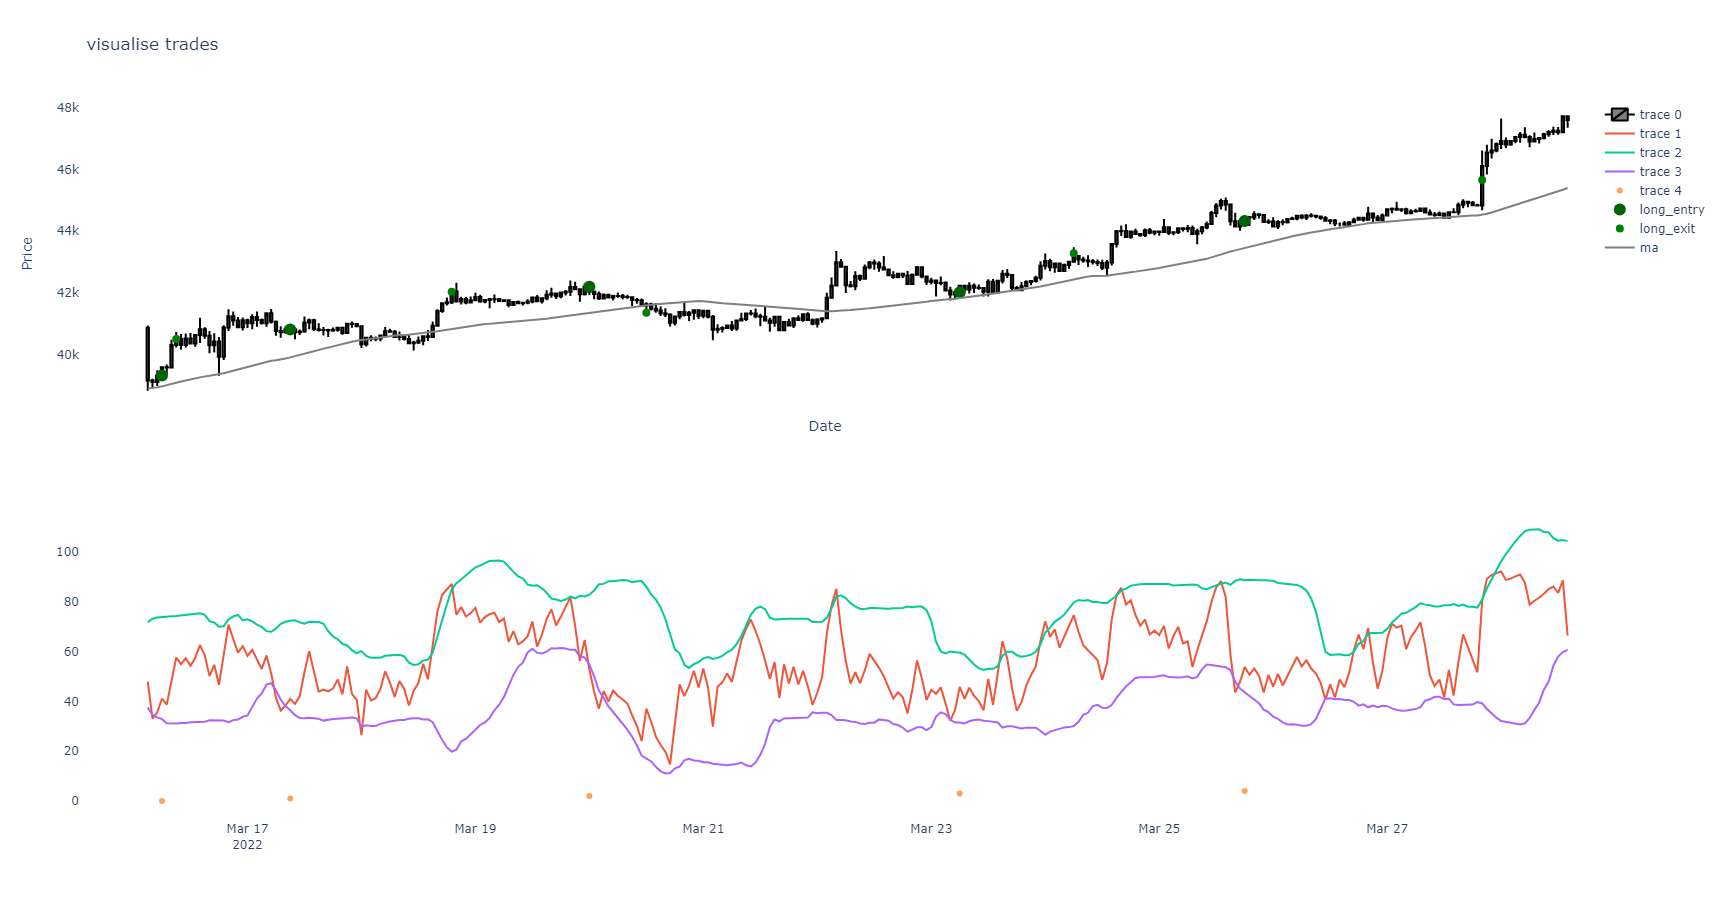

In [95]:
start_bar = 40000
end_bar = 40300
df_slice = new_df.iloc[start_bar:end_bar]
#cutoff_time = new_df.index[-(bars + 1)]
trades_slice = trades[(trades['entry_time'] >= new_df.index[start_bar]) & (trades['entry_time'] <= new_df.index[end_bar])]
#df_slice = new_df[new_df.index >= cutoff_time]

fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

fig.add_trace(
    go.Candlestick(
        x=df_slice.index,
        open=df_slice['open'],
        high=df_slice['high'],
        low=df_slice['low'],
        close=df_slice['close'],
        increasing_line_color='black',
        decreasing_line_color='black'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_slice.index,
        y=df_slice['rvi'],
        mode='lines'
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_slice.index,
        y=df_slice[f'{new_df.columns[14]}'],
        mode='lines'
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_slice.index,
        y=df_slice[f'{new_df.columns[12]}'],
        mode='lines',
    ),
    row=2, col=1
)






long_signals_df = trades_slice[trades_slice['side'] == "long"]
long_entry_points = dict(x=long_signals_df['entry_time'], y=long_signals_df['entry_price'], text=['long_entry'] * len(long_signals_df), mode='markers', name='long_entry', marker=dict(color='darkgreen', size=12))
long_exit_points = dict(x=long_signals_df['exit_time'], y=long_signals_df['exit_price'], text=['long_exit'] * len(long_signals_df), mode='markers', name='long_exit', marker=dict(color='green', size=8))

short_signals_df = trades_slice[trades_slice['side'] == "short"]
short_entry_points = dict(x=short_signals_df['entry_time'], y=short_signals_df['entry_price'], text=['short_entry'] * len(short_signals_df), mode='markers', name='short_sell', marker=dict(color='red', size=12))
short_exit_points = dict(x=short_signals_df['exit_time'], y=short_signals_df['exit_price'], text=['short_exit'] * len(short_signals_df), mode='markers', name='short_exit', marker=dict(color='red', size=8))

#test
fig.add_trace(
    go.Scatter(
        x=long_signals_df['entry_time'],
        #y=df_slice[''],
        mode='markers',
    ),
    row=2, col=1
)


fig.add_trace(go.Scatter(long_entry_points))
fig.add_trace(go.Scatter(long_exit_points))
fig.add_trace(go.Scatter(short_entry_points))
fig.add_trace(go.Scatter(short_exit_points))


fig.add_trace(go.Scatter(x=df_slice.index, y=df_slice.ma, mode='lines', name='ma', line=dict(color='grey')))
#fig.add_trace(go.Scatter(x=df_slice.index, y=df_slice[f'{df_slice.columns[7]}'], mode='lines', name='VWAP_upper', line=dict(color='grey')))

fig.update_layout(
    title='visualise trades',
    xaxis_title='Date',
    yaxis_title='Price',
    width=1200,
    height=900,
    plot_bgcolor='white',
    yaxis=dict(showgrid=False),
    xaxis=dict(showgrid=False),
    xaxis_rangeslider_visible=False  # Remove the range slider
)
fig.show()

# Optimise

In [ ]:
# Define the parameter combinations for: backtest(df, freq, fast_length, slow_length, tp, sl):
freq_values = ["1H"]
fast_ma_length_values = [5, 8, 9, 10, 13, 21, 34, 55]
slow_ma_length_values = [8, 9, 10, 13, 21, 34, 55]
tp_values = [1.01, 1.02, 1.03, 1.04, 1.05]
sl_values = [0.995, 0.99, 0.98, 0.97]

In [ ]:
results_df = pd.DataFrame(columns=["freq", "fast_ma_length", "slow_ma_length", "tp", "sl", "winrate", "amount", "equity_value", "trade_type"])

In [ ]:
# Initialize an empty list to store individual DataFrames for concatenation
dfs = []

for freq, fast_ma_length, slow_ma_length, tp, sl in itertools.product(freq_values, fast_ma_length_values, slow_ma_length_values, tp_values, sl_values):
    if fast_ma_length >= slow_ma_length:
        continue
        
    results = backtest(df, freq, fast_ma_length, slow_ma_length, tp, sl)
    long_winrate, long_amount, long_equity_value, short_winrate, short_amount, short_equity_value, overall_winrate, overall_amount, overall_equity_value = results
    
    # Create DataFrames for long, short, and overall trades
    long_df = pd.DataFrame({
        "freq": freq,
        "fast_ma_length": fast_ma_length,
        "slow_ma_length": slow_ma_length,
        "tp": tp,
        "sl": sl,
        "winrate": long_winrate,
        "amount": long_amount,
        "equity_value": long_equity_value,
        "trade_type": "long"
    }, index=[0])

    short_df = pd.DataFrame({
        "freq": freq,
        "fast_ma_length": fast_ma_length,
        "slow_ma_length": slow_ma_length,
        "tp": tp,
        "sl": sl,
        "winrate": short_winrate,
        "amount": short_amount,
        "equity_value": short_equity_value,
        "trade_type": "short"
    }, index=[0])

    overall_df = pd.DataFrame({
        "freq": freq,
        "fast_ma_length": fast_ma_length,
        "slow_ma_length": slow_ma_length,
        "tp": tp,
        "sl": sl,
        "winrate": overall_winrate,
        "amount": overall_amount,
        "equity_value": overall_equity_value,
        "trade_type": "overall"
    }, index=[0])

    # Append individual DataFrames to the list
    dfs.extend([long_df, short_df, overall_df])

# Concatenate all DataFrames in the list
results_df = pd.concat(dfs, ignore_index=True)


In [ ]:
results_df['rr'] = (results_df.tp-1)/(1-results_df.sl)

In [ ]:
results_df

In [ ]:
results_df[(results_df.winrate>45) & (results_df.rr>1)]

In [ ]:
results_df.equity_value.max()

In [ ]:
results_df[(results_df.equity_value>60000)]

In [ ]:
results_df.to_csv('BTCUSDT_close_below_fastma_optimise_v1.csv', index=True)

In [ ]:
pd.read_csv('BTCUSDT_close_below_fastma_optimise_v1.csv')